# iUROP Object Detection Benchmarking
This notebook is part of the effort to benchmark different contemporary object detection algorithms with respect to traffic analysis.

Benchmarking points:

- Detection Time (Computational Cost)
- Vehicle Count
- Average Confidence
## Import Libs

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from PIL import Image, ImageDraw, ImageFont
from datetime import datetime

from ultralytics import YOLO

from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch

## Custom Functions

In [66]:
def benchmark_summary_YOLO(results, model, data_source, data_time):
        
    benchmark_results_YOLO = pd.DataFrame(columns=['URL',
                                                   'TIME_SG',
                                                   'DETECTION_TIME',
                                                   'CAR_COUNT', 
                                                   'CAR_AVG_CONF',
                                                   'MOTOR_CYCLE_COUNT',
                                                   'MC_AVG_CONF',
                                                   'BUS_COUNT',
                                                   'BUS_AVG_CONF',
                                                   'TRUCK_COUNT',
                                                   'TRUCK_AVG_CONF'
                                                   ])
    for i, result in enumerate(results):
        
        boxes = result.boxes
        cls_tensor = boxes.cls
        conf_tensor = boxes.conf

        # Reset counts and confidence counts
        car_count = 0
        car_conf_sum = 0
        motor_cycle_count = 0
        motor_cycle_conf_sum = 0
        bus_count = 0
        bus_conf_sum = 0
        truck_count = 0
        truck_conf_sum = 0
        # Count objects
        for j in range(len(cls_tensor)):
            
            class_index = int(cls_tensor[j].item())
            class_name = model.names[class_index]

            class_confidence = conf_tensor[j].cpu()

            if class_name == 'car':
                car_count += 1
                car_conf_sum += class_confidence
            elif class_name == 'truck':
                truck_count += 1
                truck_conf_sum += class_confidence
            elif class_name == 'bus':
                bus_count += 1
                bus_conf_sum += class_confidence
            else:
                motor_cycle_count += 1
                motor_cycle_conf_sum += class_confidence
            
            print(f"Object {j+1}: {class_name} (index {class_index})", f" with confidence:{class_confidence}")    

        
        # Evaluate average confidence for the different classes & bring them from GPU to CPU memory
    
        car_AVG_conf = car_conf_sum / car_count if car_count != 0 else 'N/A'
        car_AVG_conf = car_AVG_conf.cpu().numpy() if car_AVG_conf != 'N/A' else car_AVG_conf
        bus_AVG_conf = bus_conf_sum / bus_count if bus_count != 0 else 'N/A'
        bus_AVG_conf = bus_AVG_conf.cpu().numpy() if bus_AVG_conf != 'N/A' else bus_AVG_conf
        truck_AVG_conf = truck_conf_sum / truck_count if truck_count != 0 else 'N/A'
        truck_AVG_conf = truck_AVG_conf.cpu().numpy() if truck_AVG_conf != 'N/A' else truck_AVG_conf
        MC_AVG_conf = motor_cycle_conf_sum / motor_cycle_count if motor_cycle_count != 0 else 'N/A'
        MC_AVG_conf = MC_AVG_conf.cpu().numpy() if MC_AVG_conf != 'N/A' else MC_AVG_conf

        detection_time = result.speed  
        detection_time = detection_time['preprocess'] + detection_time['inference'] + detection_time['postprocess']
        
        row = pd.DataFrame({'URL': [data_source[i]],
                            'TIME_SG':[data_time[i]],
                            'DETECTION_TIME': [detection_time],
                            'CAR_COUNT': [car_count], 
                            'CAR_AVG_CONF': [car_AVG_conf],
                            'MOTOR_CYCLE_COUNT': [motor_cycle_count],
                            'MC_AVG_CONF': [MC_AVG_conf],
                            'BUS_COUNT': [bus_count],
                            'BUS_AVG_CONF': [bus_AVG_conf],
                            'TRUCK_COUNT': [truck_count],
                            'TRUCK_AVG_CONF': [truck_AVG_conf]})
        

        #result.show()
        benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)

    return benchmark_results_YOLO

def benchmark_summary_transformer(results, model, detection_time, data_source, data_time): 

    benchmark_results_transformer = pd.DataFrame(columns=['URL',
                                                   'TIME_SG',
                                                   'DETECTION_TIME',
                                                   'CAR_COUNT', 
                                                   'CAR_AVG_CONF',
                                                   'CAR_BOXES',
                                                   'MOTOR_CYCLE_COUNT',
                                                   'MC_AVG_CONF',
                                                   'MC_BOXES',
                                                   'BUS_COUNT',
                                                   'BUS_AVG_CONF',
                                                   'BUS_BOXES'
                                                   'MC_BOXES',
                                                   'TRUCK_COUNT',
                                                   'TRUCK_AVG_CONF',
                                                   'TRUCK_BOXES']
                                                    )
    for i, result in enumerate(results):

        # Reset counts and confidence counts
        car_count = 0
        car_conf_sum = 0
        car_boxes = []
        motor_cycle_count = 0
        motor_cycle_conf_sum = 0
        mc_boxes = []
        bus_count = 0
        bus_conf_sum = 0
        bus_boxes = []
        truck_count = 0
        truck_conf_sum = 0                                                                             
        truck_boxes = []

        for score, label, boxlist in zip(result["scores"], result["labels"], result["boxes"]):

            label = model.config.id2label[label.item()]    
            # let's only keep detections with score > DETECTION_THRESHOLD
            if (score.item() > DETECTION_THRESHOLD and label in NEEDED_LABELS):
                box = [int(j) for j in boxlist.tolist()]
            print(f"Detected object with label {label} and score {score}")
            print(f"Bounding box coordinates: {box}")

            if label == 'car':
                car_count += 1
                car_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                car_boxes.append(box)
            elif label == 'truck':
                truck_count += 1
                truck_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                truck_boxes.append(box)
            elif label == 'bus':
                bus_count += 1
                bus_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                bus_boxes.append(box)
            elif label == 'motorcycle':
                motor_cycle_count += 1
                motor_cycle_conf_sum += score.detach().numpy()  # Detach and convert to numpy
                mc_boxes.append(box)

        # Evaluate average confidence for the different classes
        print(f"Car count: {car_count}",type(car_boxes))
        car_AVG_conf = car_conf_sum / car_count if car_count != 0 else 'N/A'
        
        bus_AVG_conf = bus_conf_sum / bus_count if bus_count != 0 else 'N/A'
        
        truck_AVG_conf = truck_conf_sum / truck_count if truck_count != 0 else 'N/A'
        
        MC_AVG_conf = motor_cycle_conf_sum / motor_cycle_count if motor_cycle_count != 0 else 'N/A'
       

        row = pd.DataFrame({'URL': [data_source[i]],
                            'TIME_SG':[data_time[i]],
                            'DETECTION_TIME': [detection_time],
                            'CAR_COUNT': [car_count],
                            'CAR_AVG_CONF': [car_AVG_conf],
                            'CAR_BOXES': [car_boxes], 
                            'MOTOR_CYCLE_COUNT': [motor_cycle_count],
                            'MC_AVG_CONF': [MC_AVG_conf],
                            'MC_BOXES': [mc_boxes], 
                            'BUS_COUNT': [bus_count],
                            'BUS_AVG_CONF': [bus_AVG_conf],
                            'BUS_BOXES': [bus_boxes], 
                            'TRUCK_COUNT': [truck_count],
                            'TRUCK_AVG_CONF': [truck_AVG_conf],
                            'TRUCK_BOXES': [bus_boxes]
                            })
        
       
        benchmark_results_transformer = pd.concat([benchmark_results_transformer, row], ignore_index=True)

    return benchmark_results_transformer

def sort_by_time_of_day(df, datetime_col):
   
    # Convert the datetime column to datetime if it's not already
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # Extract the time
    df['TIME_ONLY'] = df[datetime_col].dt.time

    # Sort by the 'TIME_ONLY' column
    df_sorted = df.sort_values(by='TIME_ONLY')

    # Drop the 'TIME_ONLY' column 
    df_sorted = df_sorted.drop(columns=['TIME_ONLY'])

    return df_sorted

def remove_na_from_lists(*lists):
    cleaned_lists = []
    for lst in lists:
        cleaned_list = [conf for conf in lst if conf != 'N/A']
        cleaned_lists.append(cleaned_list)
    return cleaned_lists


## Accessing Example
For first prototyping the camera 2703 is choosen 

In [67]:
bm_data = pd.read_excel('example_data.xlsx',sheet_name='in')
bm_data.head()

,Unnamed: 0,Image_id,Cam_ID,Detection_Class,Detection_Score,Timestamp_sg_time,URL,ymin,xmin,ymax,xmax,Bounding_box_area,Proportion_bounding_box_0_100,Segmentation_pixels
0,0,0,2703,3,0.578911,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,245.54533,577.65643,273.81723,613.67883,1018.4216,0.049114,0.002501
1,1,0,2703,8,0.236422,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,245.73334,577.16020,275.06482,614.46740,1094.2751,0.052772,0.003661
2,2,0,2703,5,0.150083,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,479.06200,1316.72000,510.78333,1392.13530,2392.2717,0.115368,0.006059
3,3,0,2703,7,0.108866,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,165.20915,0.00000,1026.82870,817.30990,704210.2000,33.960754,0.011771
4,4,0,2703,8,0.051746,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...,247.07472,579.08545,268.10458,603.35190,510.3207,0.024610,0.021770


In [68]:
bm_data = bm_data[['Timestamp_sg_time','URL']]
bm_data.head()

,Timestamp_sg_time,URL
0,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
1,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
2,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
3,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
4,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...


Removing the duplicated rows:

In [69]:
bm_data.drop_duplicates(inplace=True)
bm_data.head()

,Timestamp_sg_time,URL
0,2022-04-11 04:50:00,https://images.data.gov.sg/api/traffic-images/...
6,2022-04-11 04:55:00,https://images.data.gov.sg/api/traffic-images/...
14,2022-04-11 05:00:00,https://images.data.gov.sg/api/traffic-images/...
24,2022-04-11 05:05:00,https://images.data.gov.sg/api/traffic-images/...
39,2022-04-11 05:10:00,https://images.data.gov.sg/api/traffic-images/...


In [70]:
print(bm_data.shape[0], "images are available!")

228 images are available!


## Import YOLO Model(s)

In [71]:
# Load COCO-pretrained YOLO11x model
YOLO_11x = YOLO("yolo11x.pt")
# Load COCO-pretrained YOLO11n model
YOLO_11n = YOLO("yolo11n.pt")

# Load COCO-pretrained YOLO5xu model
YOLO_5xu = YOLO("yolov5x.pt")

PRO TIP  Replace 'model=yolov5x.pt' with new 'model=yolov5xu.pt'.
YOLOv5 'u' models are trained with https://github.com/ultralytics/ultralytics and feature improved performance vs standard YOLOv5 models trained with https://github.com/ultralytics/yolov5.



## Load RESNET

In [72]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
transformer_resnet_50 = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
def detect_object_using_transformer(image):

    start_time = datetime.now()
    # Preprocessing
    inputs = feature_extractor(images=image, return_tensors="pt")
    
    # Inference
    outputs = transformer_resnet_50(**inputs)

    # Postprocessing: convert outputs (bounding boxes and class logits) to COCO API
    target_sizes = torch.tensor([image.size[::-1]])
    
    results = feature_extractor.post_process_object_detection(outputs, target_sizes=target_sizes)[0]
    detection_time = (datetime.now() - start_time).microseconds * 0.001 # Miliseconds

    return results, detection_time

c:\Users\f-bon\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if y

## Inference & Benchmarking

In [73]:
# Select a sample of images:
n_randoms_images = 20
rand_images = bm_data.sample(n=n_randoms_images, random_state=22)
rand_images_URL = rand_images['URL'].to_list()
rand_images_time = rand_images['Timestamp_sg_time'].to_list()


In [74]:
desired_classes = [2,3,5,7] # Detect cars, motorcycles, busses and trucks
results_11x = YOLO_11x(rand_images_URL, classes = desired_classes) 
results_11n = YOLO_11n(rand_images_URL, classes = desired_classes) 
results_5xu = YOLO_5xu(rand_images_URL, classes = desired_classes) 

results_transformer = []
detection_times = []
for url in rand_images_URL:
    image = Image.open(requests.get(url, stream=True).raw)
    result, detection_time = detect_object_using_transformer(image)
    results_transformer.append(result)
    detection_times.append(detection_time)





0: 384x640 6 cars, 2 motorcycles, 3 trucks, 2601.1ms
1: 384x640 15 cars, 3 trucks, 2601.1ms
2: 384x640 9 cars, 5 trucks, 2601.1ms
3: 384x640 18 cars, 1 motorcycle, 2601.1ms
4: 384x640 7 cars, 2 trucks, 2601.1ms
5: 384x640 7 cars, 1 bus, 2601.1ms
6: 384x640 14 cars, 1 motorcycle, 1 truck, 2601.1ms
7: 384x640 12 cars, 1 truck, 2601.1ms
8: 384x640 14 cars, 2 motorcycles, 4 trucks, 2601.1ms
9: 384x640 12 cars, 2 buss, 1 truck, 2601.1ms
10: 384x640 7 cars, 1 bus, 2 trucks, 2601.1ms
11: 384x640 14 cars, 1 motorcycle, 3 buss, 4 trucks, 2601.1ms
12: 384x640 8 cars, 1 bus, 2 trucks, 2601.1ms
13: 384x640 7 cars, 1 motorcycle, 4 trucks, 2601.1ms
14: 384x640 9 cars, 2 buss, 2601.1ms
15: 384x640 11 cars, 1 bus, 2 trucks, 2601.1ms
16: 384x640 6 cars, 1 truck, 2601.1ms
17: 384x640 16 cars, 1 bus, 2 trucks, 2601.1ms
18: 384x640 6 cars, 3 trucks, 2601.1ms
19: 384x640 11 cars, 1 truck, 2601.1ms
Speed: 5.1ms preprocess, 2601.1ms inference, 2.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x64

c:\Users\f-bon\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


0: 384x640 8 cars, 2 motorcycles, 2 trucks, 2712.9ms
1: 384x640 16 cars, 5 trucks, 2712.9ms
2: 384x640 11 cars, 5 trucks, 2712.9ms
3: 384x640 17 cars, 1 motorcycle, 2 trucks, 2712.9ms
4: 384x640 7 cars, 1 truck, 2712.9ms
5: 384x640 7 cars, 2712.9ms
6: 384x640 14 cars, 2 trucks, 2712.9ms
7: 384x640 9 cars, 1 truck, 2712.9ms
8: 384x640 17 cars, 2 motorcycles, 2 trucks, 2712.9ms
9: 384x640 10 cars, 1 truck, 2712.9ms
10: 384x640 7 cars, 3 trucks, 2712.9ms
11: 384x640 12 cars, 1 motorcycle, 4 buss, 4 trucks, 2712.9ms
12: 384x640 8 cars, 1 bus, 1 truck, 2712.9ms
13: 384x640 8 cars, 1 motorcycle, 5 trucks, 2712.9ms
14: 384x640 7 cars, 1 bus, 2 trucks, 2712.9ms
15: 384x640 14 cars, 1 bus, 1 truck, 2712.9ms
16: 384x640 4 cars, 1 truck, 2712.9ms
17: 384x640 17 cars, 1 bus, 4 trucks, 2712.9ms
18: 384x640 8 cars, 3 trucks, 2712.9ms
19: 384x640 11 cars, 2 trucks, 2712.9ms
Speed: 2.5ms preprocess, 2712.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


#### Yolo 11x

In [75]:
benchmark_results_YOLO_11x = benchmark_summary_YOLO(results = results_11x, 
                                                    model = YOLO_11x, 
                                                    data_source = rand_images_URL,
                                                    data_time = rand_images_time
                                                    )
benchmark_results_YOLO_11x = sort_by_time_of_day(benchmark_results_YOLO_11x, 'TIME_SG')
benchmark_results_YOLO_11x.head(5)


Object 1: car (index 2)  with confidence:0.9119121432304382
Object 2: car (index 2)  with confidence:0.8439515829086304
Object 3: car (index 2)  with confidence:0.7461462616920471
Object 4: truck (index 7)  with confidence:0.6755207180976868
Object 5: truck (index 7)  with confidence:0.5360451340675354
Object 6: truck (index 7)  with confidence:0.5282171368598938
Object 7: motorcycle (index 3)  with confidence:0.5109204649925232
Object 8: motorcycle (index 3)  with confidence:0.4029242992401123
Object 9: car (index 2)  with confidence:0.39922893047332764
Object 10: car (index 2)  with confidence:0.3583798110485077
Object 11: car (index 2)  with confidence:0.2731180787086487
Object 1: car (index 2)  with confidence:0.8986969590187073
Object 2: car (index 2)  with confidence:0.8897921442985535
Object 3: car (index 2)  with confidence:0.8101764917373657
Object 4: car (index 2)  with confidence:0.7135390043258667
Object 5: car (index 2)  with confidence:0.6735348105430603
Object 6: car (in

C:\Users\f-bon\AppData\Local\Temp\ipykernel_7288\640295656.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,MOTOR_CYCLE_COUNT,MC_AVG_CONF,BUS_COUNT,BUS_AVG_CONF,TRUCK_COUNT,TRUCK_AVG_CONF
11,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:30:00,2608.69875,14,0.5688394,1,0.685254,3,0.7197085,4,0.582585
6,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:50:00,2608.69875,14,0.5630732,1,0.37179413,0,N/A,1,0.9437221
17,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:15:00,2608.69875,16,0.6357889,0,N/A,1,0.7664811,2,0.64015234
3,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:40:00,2608.69875,18,0.58583164,1,0.26926067,0,N/A,0,N/A
19,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 09:00:00,2608.69875,11,0.58105034,0,N/A,0,N/A,1,0.57687557


### Yolo 11n

In [76]:
benchmark_results_YOLO_11n = benchmark_summary_YOLO(results = results_11n, 
                                                    model = YOLO_11n, 
                                                    data_source = rand_images_URL,
                                                    data_time = rand_images_time
                                                    )
benchmark_results_YOLO_11n = sort_by_time_of_day(benchmark_results_YOLO_11n, 'TIME_SG')
benchmark_results_YOLO_11n.head()

Object 1: car (index 2)  with confidence:0.796441376209259
Object 2: car (index 2)  with confidence:0.6605139970779419
Object 3: car (index 2)  with confidence:0.5763643383979797
Object 4: car (index 2)  with confidence:0.3805946111679077
Object 5: car (index 2)  with confidence:0.3365563154220581
Object 6: truck (index 7)  with confidence:0.32588833570480347
Object 7: car (index 2)  with confidence:0.3194424510002136
Object 8: truck (index 7)  with confidence:0.3138244152069092
Object 9: car (index 2)  with confidence:0.27365627884864807
Object 1: car (index 2)  with confidence:0.866010844707489
Object 2: car (index 2)  with confidence:0.782792866230011
Object 3: car (index 2)  with confidence:0.6995297074317932
Object 4: car (index 2)  with confidence:0.6910951733589172
Object 5: car (index 2)  with confidence:0.6899041533470154
Object 6: car (index 2)  with confidence:0.678516685962677
Object 7: car (index 2)  with confidence:0.661946177482605
Object 8: car (index 2)  with confidenc

C:\Users\f-bon\AppData\Local\Temp\ipykernel_7288\640295656.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,MOTOR_CYCLE_COUNT,MC_AVG_CONF,BUS_COUNT,BUS_AVG_CONF,TRUCK_COUNT,TRUCK_AVG_CONF
11,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:30:00,305.575347,12,0.47854877,2,0.27215463,2,0.5175446,1,0.43566096
6,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:50:00,305.575347,7,0.54679716,0,N/A,0,N/A,1,0.6785926
17,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:15:00,305.575347,10,0.5634867,0,N/A,0,N/A,2,0.44386134
3,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:40:00,305.575347,12,0.5803511,0,N/A,0,N/A,0,N/A
19,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 09:00:00,305.575347,8,0.5342576,0,N/A,0,N/A,0,N/A


### YOLO 5xu

In [77]:
benchmark_results_YOLO_5xu = benchmark_summary_YOLO(results = results_5xu, 
                                                    model = YOLO_5xu, 
                                                    data_source = rand_images_URL,
                                                    data_time = rand_images_time
                                                    )
benchmark_results_YOLO_5xu = sort_by_time_of_day(benchmark_results_YOLO_5xu, 'TIME_SG')
benchmark_results_YOLO_5xu.head()

Object 1: car (index 2)  with confidence:0.8822957873344421
Object 2: truck (index 7)  with confidence:0.7798069715499878
Object 3: car (index 2)  with confidence:0.7432963252067566
Object 4: car (index 2)  with confidence:0.6421040296554565
Object 5: truck (index 7)  with confidence:0.6238008141517639
Object 6: car (index 2)  with confidence:0.5703287720680237
Object 7: car (index 2)  with confidence:0.5400828123092651
Object 8: motorcycle (index 3)  with confidence:0.5345633625984192
Object 9: car (index 2)  with confidence:0.5245585441589355
Object 10: car (index 2)  with confidence:0.4472104012966156
Object 11: car (index 2)  with confidence:0.33721843361854553
Object 12: motorcycle (index 3)  with confidence:0.2991634011268616
Object 1: car (index 2)  with confidence:0.8717846274375916
Object 2: car (index 2)  with confidence:0.8383581042289734
Object 3: car (index 2)  with confidence:0.8153331279754639
Object 4: car (index 2)  with confidence:0.7765317559242249
Object 5: car (ind

C:\Users\f-bon\AppData\Local\Temp\ipykernel_7288\640295656.py:82: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_YOLO = pd.concat([benchmark_results_YOLO, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,MOTOR_CYCLE_COUNT,MC_AVG_CONF,BUS_COUNT,BUS_AVG_CONF,TRUCK_COUNT,TRUCK_AVG_CONF
11,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:30:00,2717.116523,12,0.60378116,1,0.61832297,4,0.51679695,4,0.5479981
6,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:50:00,2717.116523,14,0.5722338,0,N/A,0,N/A,2,0.8425349
17,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:15:00,2717.116523,17,0.54500866,0,N/A,1,0.47720557,4,0.6452119
3,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:40:00,2717.116523,17,0.64877486,1,0.31509286,0,N/A,2,0.5694833
19,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 09:00:00,2717.116523,11,0.524741,0,N/A,0,N/A,2,0.52797246


### RESNET-50

In [78]:
DETECTION_THRESHOLD = 0.2
NEEDED_LABELS = ["bus", "car", "truck", "motorcycle"]
benchmark_results_transformer = benchmark_summary_transformer(results = results_transformer, 
                                        model = transformer_resnet_50, 
                                        detection_time = detection_time,
                                        data_source = rand_images_URL,
                                        data_time = rand_images_time
                                        )

benchmark_results_transformer = sort_by_time_of_day(benchmark_results_transformer, 'TIME_SG')
benchmark_results_transformer.head()

Detected object with label car and score 0.813465416431427
Bounding box coordinates: [835, 128, 851, 141]
Detected object with label car and score 0.7500216960906982
Bounding box coordinates: [846, 127, 862, 140]
Detected object with label car and score 0.7117077708244324
Bounding box coordinates: [712, 114, 733, 132]
Detected object with label car and score 0.9919214248657227
Bounding box coordinates: [764, 255, 802, 291]
Detected object with label truck and score 0.681506872177124
Bounding box coordinates: [575, 211, 606, 234]
Detected object with label car and score 0.5646129846572876
Bounding box coordinates: [677, 126, 700, 146]
Detected object with label car and score 0.6449668407440186
Bounding box coordinates: [688, 108, 709, 123]
Detected object with label car and score 0.7671030759811401
Bounding box coordinates: [1056, 247, 1089, 266]
Detected object with label car and score 0.5681915283203125
Bounding box coordinates: [705, 119, 725, 137]
Detected object with label car and 

C:\Users\f-bon\AppData\Local\Temp\ipykernel_7288\640295656.py:176: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  benchmark_results_transformer = pd.concat([benchmark_results_transformer, row], ignore_index=True)


,URL,TIME_SG,DETECTION_TIME,CAR_COUNT,CAR_AVG_CONF,CAR_BOXES,MOTOR_CYCLE_COUNT,MC_AVG_CONF,MC_BOXES,BUS_COUNT,BUS_AVG_CONF,BUS_BOXESMC_BOXES,TRUCK_COUNT,TRUCK_AVG_CONF,TRUCK_BOXES,BUS_BOXES
11,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:30:00,62.442,22,0.783071,"[[187, 372, 272, 422], [329, 509, 455, 603], [...",2,0.751218,"[[1730, 895, 1814, 1030], [1739, 939, 1805, 10...",1,0.961337,NaN,12,0.873907,"[[1373, 453, 1761, 751]]","[[1373, 453, 1761, 751]]"
6,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 07:50:00,62.442,28,0.764578,"[[872, 159, 897, 183], [805, 136, 830, 159], [...",5,0.901338,"[[1009, 296, 1032, 331], [806, 296, 824, 329],...",0,N/A,NaN,2,0.79313,[],[]
17,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:15:00,62.442,24,0.809276,"[[881, 179, 908, 204], [650, 187, 679, 209], [...",0,N/A,[],0,N/A,NaN,14,0.655496,[],[]
3,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 08:40:00,62.442,35,0.804356,"[[891, 154, 914, 174], [910, 148, 932, 167], [...",1,0.94419,"[[1069, 297, 1090, 326]]",0,N/A,NaN,4,0.780092,[],[]
19,https://images.data.gov.sg/api/traffic-images/...,2022-04-11 09:00:00,62.442,33,0.708745,"[[876, 139, 896, 158], [881, 130, 901, 147], [...",0,N/A,[],0,N/A,NaN,12,0.720358,[],[]


## Model Cross-Comparisson

### Car Detection & Confidence

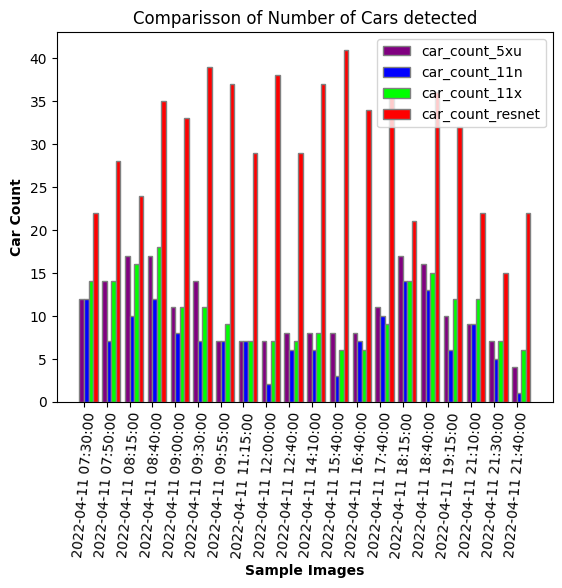

In [89]:
# Sample data
categories = [f'{time}' for time in benchmark_results_YOLO_11n['TIME_SG']]

car_count_5xu = benchmark_results_YOLO_5xu['CAR_COUNT'].to_list()
car_count_11n = benchmark_results_YOLO_11n['CAR_COUNT'].to_list()
car_count_11x = benchmark_results_YOLO_11x['CAR_COUNT'].to_list()
car_count_resnet = benchmark_results_transformer['CAR_COUNT'].to_list()

# Define the width of the bars
bar_width = 0.2

# Set the positions of the bars on the x-axis
r0 = np.arange(len(categories))
r1 = [x + bar_width for x in r0]
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create the block plot
plt.bar(r0, car_count_5xu, color='purple', width=bar_width, edgecolor='grey', label='car_count_5xu')
plt.bar(r1, car_count_11n, color='blue', width=bar_width, edgecolor='grey', label='car_count_11n')
plt.bar(r2, car_count_11x, color='lime', width=bar_width, edgecolor='grey', label='car_count_11x')
plt.bar(r3, car_count_resnet, color='red', width=bar_width, edgecolor='grey', label='car_count_resnet')

# Add labels
plt.xlabel('Sample Images', fontweight='bold')
plt.ylabel('Car Count', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories, rotation = 85)

# Add legend
plt.legend()

# Show the plot
plt.title('Comparisson of Number of Cars detected')
plt.show()

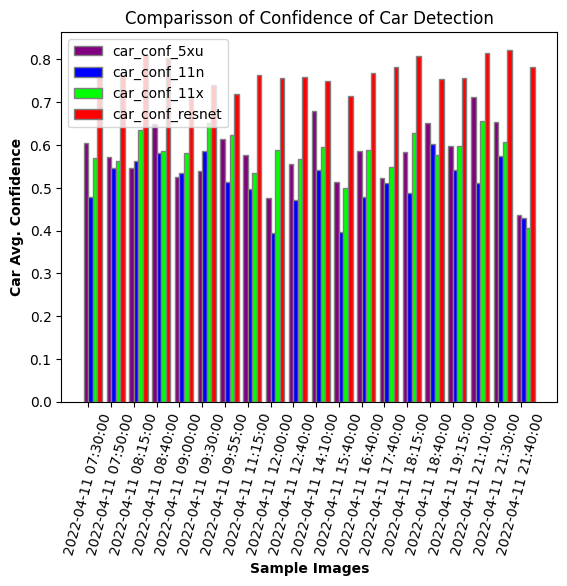

In [91]:
# Sample data
car_confidence_5xu = benchmark_results_YOLO_5xu['CAR_AVG_CONF'].to_list()
car_confidence_11n = benchmark_results_YOLO_11n['CAR_AVG_CONF'].to_list()
car_confidence_11x = benchmark_results_YOLO_11x['CAR_AVG_CONF'].to_list()
car_confidence_resnet = benchmark_results_transformer['CAR_AVG_CONF'].to_list()

# Create the block plot
plt.bar(r0, car_confidence_5xu, color='purple', width=bar_width, edgecolor='grey', label='car_conf_5xu')
plt.bar(r1, car_confidence_11n, color='blue', width=bar_width, edgecolor='grey', label='car_conf_11n')
plt.bar(r2, car_confidence_11x, color='lime', width=bar_width, edgecolor='grey', label='car_conf_11x')
plt.bar(r3, car_confidence_resnet, color='red', width=bar_width, edgecolor='grey', label='car_conf_resnet')

# Add labels
plt.xlabel('Sample Images', fontweight='bold')
plt.ylabel('Car Avg. Confidence', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories, rotation = 75)

# Add legend
plt.legend()

# Show the plot
plt.title('Comparisson of Confidence of Car Detection')
plt.show()

[0.5688393712043762, 0.5630732178688049, 0.6357889175415039, 0.5858316421508789, 0.5810503363609314, 0.650817334651947, 0.6222598552703857, 0.533644437789917, 0.5874791145324707, 0.567384660243988, 0.5953332185745239, 0.49831709265708923, 0.5887894630432129, 0.5474886298179626, 0.6272731423377991, 0.5769078731536865, 0.5982258915901184, 0.6556944847106934, 0.6059908270835876, 0.40701010823249817]


C:\Users\f-bon\AppData\Local\Temp\ipykernel_7288\2005320426.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='Confidence', data=df_box_conf, palette='Set2')


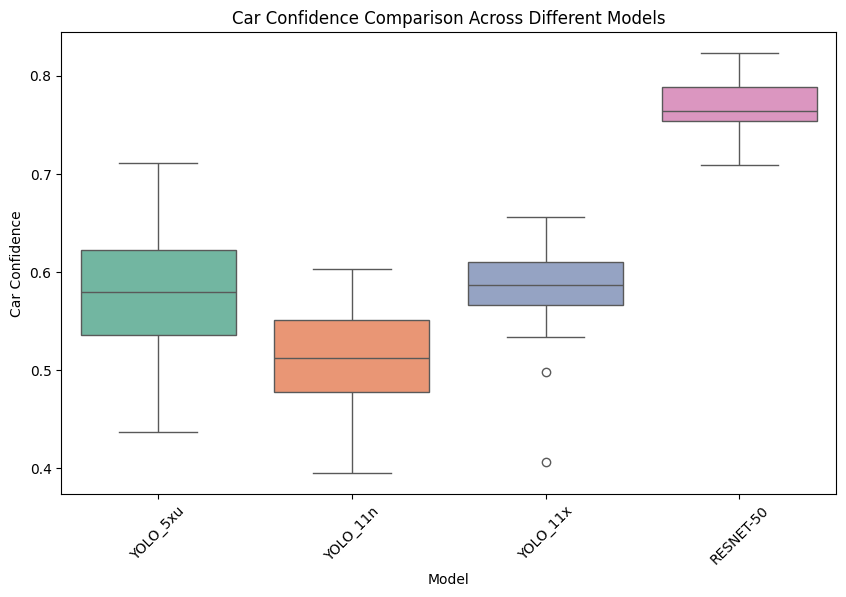

In [87]:
# Create the DataFrame
car_confidence_lists = [car_confidence_5xu, car_confidence_11n, car_confidence_11x, car_confidence_resnet]

car_confidence_5xu, car_confidence_11n, car_confidence_11x, car_confidence_resnet = remove_na_from_lists(car_confidence_5xu ,car_confidence_11n, car_confidence_11x,car_confidence_resnet)

car_confidence_5xu = [float(conf) for conf in car_confidence_5xu]
car_confidence_11n = [float(conf) for conf in car_confidence_11n]
car_confidence_11x = [float(conf) for conf in car_confidence_11x]
car_confidence_resnet = [float(conf) for conf in car_confidence_resnet]

box_plot_data = {
    'Model': ['YOLO_5xu'] * len(car_confidence_5xu) + ['YOLO_11n'] * len(car_confidence_11n) + ['YOLO_11x'] * len(car_confidence_11x) + ['RESNET-50'] * len(car_confidence_resnet),
    'Confidence': car_confidence_5xu + car_confidence_11n + car_confidence_11x + car_confidence_resnet
}

df_box_conf = pd.DataFrame(box_plot_data)
# Convert the 'Confidence' column to numeric type
df_box_conf['Confidence'] = pd.to_numeric(df_box_conf['Confidence'], errors='coerce')

print(car_confidence_11x)
df_box_conf.head()
# Create the box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='Confidence', data=df_box_conf, palette='Set2')

plt.title('Car Confidence Comparison Across Different Models')
plt.xlabel('Model')
plt.ylabel('Car Confidence')
plt.xticks(rotation=45)

plt.show()